In [4275]:
import torch
from torch.utils.data import DataLoader # loads data either in chunks or full
import torch.nn.functional as F
from torchvision import datasets # open datasets
from torchvision.transforms import ToTensor # transfor data to tensor
import matplotlib.pyplot as plt
import math

In [4276]:
# choosing gpu for training
device = ("cuda:0" if torch.cuda.is_available() else "cpu")
device

'cuda:0'

In [4277]:
# download training and test data from open datasets.
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4278]:
# loading the data
train_dataloader = DataLoader(train_data, batch_size=64) # goes over 938 batches of 64
test_dataloader = DataLoader(test_data, batch_size=64)

Name: Shirt, Number: 6


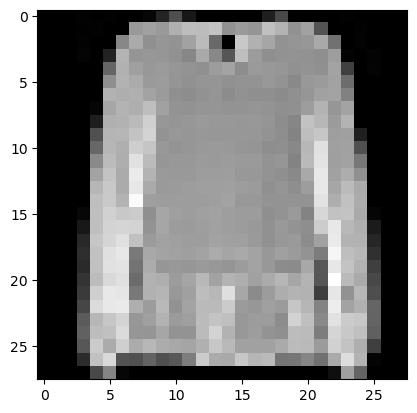

In [4279]:
# plotting and understanding images and labels with first batch

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

images, labels = next(iter(train_dataloader))
idx = torch.randint(0, 64, (1,)).item()
image = images[idx].squeeze()
label = labels[idx]
print(f"Name: {labels_map[label.item()]}, Number: {label.item()}")
plt.imshow(image, cmap="grey")
plt.show()

In [4280]:
# processed_train_data_x = []
# processed_train_data_y = []

# for batch, (x, y) in enumerate(train_dataloader):
#     x, y = x.to("cuda:0"), y.to("cuda:0")

#     for xi, yi in zip(x, y):
#         flattened_xi = torch.flatten(xi)
#         processed_train_data_x.append(flattened_xi)
#         processed_train_data_y.append(yi)

# stacked_train_data_x = torch.stack(processed_train_data_x, dim=0)
# stacked_train_data_y = torch.tensor(processed_train_data_y)

# print("Shape of stacked_train_data_x:", stacked_train_data_x.shape)
# print("Shape of stacked_train_data_y:", stacked_train_data_y.shape)

# stacked_train_data_x = stacked_train_data_x.to(device)
# stacked_train_data_y = stacked_train_data_y.to(device)

In [4286]:
# implementing MLP

class Neuron:
    # nin is number of inputs
    def __init__(self, nin):
        self.w = torch.randn((nin[0], nin[1]), requires_grad=True, device="cuda:0")
        # self.w = self.w * 2 - 1  # Not in-place, creates a new tensor
        # self.w.retain_grad()
        self.b = torch.randn(1, requires_grad=True, device="cuda:0")
    
    # x is how many inputs
    def __call__(self, x):
        act = torch.matmul(self.w, x) + self.b  # matrix multiplication with compatible shapes
        out = torch.sigmoid(act)
        # print(torch.min(self.w))
        return out  # tensor of 1D with 1 value
    
    def parameters(self):
        params = [self.w, self.b]
        # print(params)
        return params
    
class Layer:
    def __init__(self, nin, nout):
        # create nout neurons with nin inputs
        # the amount of neurons is based on how many outputs we need
        self.neurons = [Neuron(nin) for _ in range(nout)] # list of neurons
    
    # x is how many neurons
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return torch.stack(outs)
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    # nin is number of inputs
    # nouts is the list of number of outputs/neurons per each layer
    def __init__(self, nin, nouts, lr):
        self.lr = lr
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
    
    # bruh this is forward propagation?? weird
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x) # x is the input from the other neurons
        return torch.softmax(x, dim=0)
    
    def parameters(self):
        # params = torch.stack([p for layer in self.layers for p in layer.parameters()])
        return [p for layer in self.layers for p in layer.parameters()]
    
    def update_parameters(self):
        with torch.no_grad():
            for param in self.parameters():
                if param is not None:
                    param -= torch.mul(param.grad, self.lr)
                    param.grad.zero_()
    
    def zero_grads(self):
        with torch.no_grad():
            for param in self.parameters():
                if param.grad is not None:
                    param.grad.zero_()
    

In [4287]:
mlp = MLP([1, 784], [12, 12, 10], lr=0.09)

TypeError: 'int' object is not subscriptable

In [4283]:
def validation(mlp):
    tot = 0
    wrong = 0
    right = 0

    for batch, (test_x, test_y) in enumerate(test_dataloader):
        test_x, test_y = test_x.to(device), test_y.to(device)

        for xi, yi in zip(test_x, test_y):
            flattened = torch.flatten(xi)
            output = mlp(flattened)

            index = torch.argmax(output)

            if index.item() == yi.item():
                right += 1
            else: 
                wrong += 1

            tot += 1

    right_ratio = right / tot * 100
    print(f"Test Accuracy: {right_ratio}\n")

In [4284]:
# criterion = torch.nn.CrossEntropyLoss()

# for i in range(5):
#     print(f"Epoch {i + 1}")
#     print("-----------------------------------------")

#     loop = 1
#     loss = 0
#     batch = 0

#     for xi, yi in zip(stacked_train_data_x, stacked_train_data_y):

#         # print("Input shape:", xi.shape)
#         # print("Label:", yi)

#         output = mlp(xi)
#         output = output.squeeze()

#         loss += criterion(output, yi)

#         if loop % 64 == 0:
#             mlp.zero_grads()
#             loss.backward()
#             mlp.update_parameters()

#             if batch % 100 == 0:
#                 print(f"Loss: {loss:>7f}\t [{((batch + 1) * 64):>5d}/{937 * 64}]")

#             loop = 1
#             loss = 0
#             batch += 1

#         else:
#             loop += 1

#     # for batch, (x, y) in enumerate(train_dataloader):
#     #     x, y = x.to("cuda:0"), y.to("cuda:0")

#     #     l = 0.0
#     #     for xi, yi in zip(x, y):
#     #         flattened = torch.flatten(xi)
#     #         output = mlp(flattened)
#     #         output = output.squeeze()

#     #         l += criterion(output, yi)
        
#     #     mlp.zero_grads()
#     #     l.backward()
#     #     mlp.update_parameters()

        
    
#     # validation(mlp)

In [4285]:
criterion = torch.nn.CrossEntropyLoss()

for i in range(5):
    print(f"Epoch {i + 1}")
    print("-----------------------------------------")
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.to("cuda:0"), y.to("cuda:0")

        l = 0.0
        for xi, yi in zip(x, y):
            flattened = torch.flatten(xi)
            output = mlp(flattened)
            output = output.squeeze()

            l += criterion(output, yi)
        
        # mlp.zero_grads()
        l.backward()
        mlp.update_parameters()

        if batch % 100 == 0:
            print(f"Loss: {l:>7f}\t [{((batch + 1) * 64):>5d}/{937 * 64}]")
    
    validation(mlp)

Epoch 1
-----------------------------------------
Loss: 147.179306	 [   64/59968]
Loss: 146.483963	 [ 6464/59968]
Loss: 145.725922	 [12864/59968]
Loss: 145.419632	 [19264/59968]
Loss: 144.654037	 [25664/59968]
Loss: 144.194473	 [32064/59968]
Loss: 144.200943	 [38464/59968]
Loss: 143.852524	 [44864/59968]
Loss: 143.439041	 [51264/59968]
Loss: 143.516464	 [57664/59968]
Test Accuracy: 36.02

Epoch 2
-----------------------------------------
Loss: 143.267899	 [   64/59968]
Loss: 143.789551	 [ 6464/59968]
Loss: 142.961060	 [12864/59968]
Loss: 143.914902	 [19264/59968]
Loss: 143.373367	 [25664/59968]
Loss: 143.086029	 [32064/59968]
Loss: 143.413788	 [38464/59968]
Loss: 143.015915	 [44864/59968]
Loss: 142.539169	 [51264/59968]
Loss: 142.996857	 [57664/59968]
Test Accuracy: 37.16

Epoch 3
-----------------------------------------
Loss: 142.506271	 [   64/59968]
Loss: 143.189072	 [ 6464/59968]
Loss: 142.495880	 [12864/59968]
Loss: 143.504166	 [19264/59968]
Loss: 142.982803	 [25664/59968]
Loss: 

KeyboardInterrupt: 

WRONG
Predicted: Sandal, Number: 0.19249491393566132
Target: Ankle Boot, Number: 9


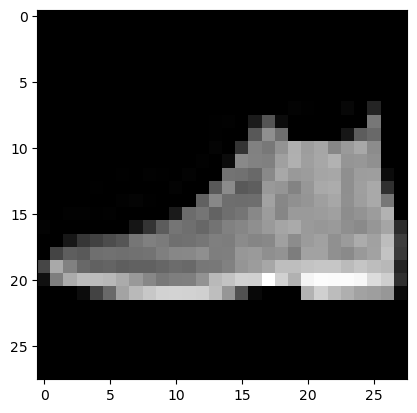

WRONG
Predicted: Coat, Number: 0.1787239909172058
Target: Pullover, Number: 2


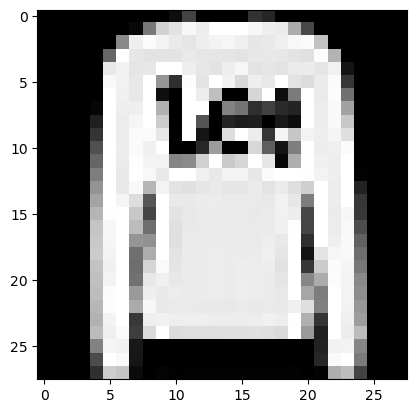

RIGHT
Predicted: Trouser, Number: 0.22964029014110565
Target: Trouser, Number: 1


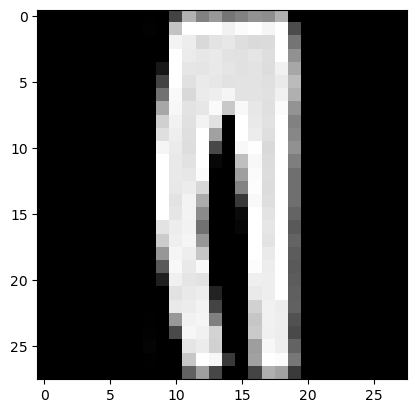

RIGHT
Predicted: Trouser, Number: 0.2296587973833084
Target: Trouser, Number: 1


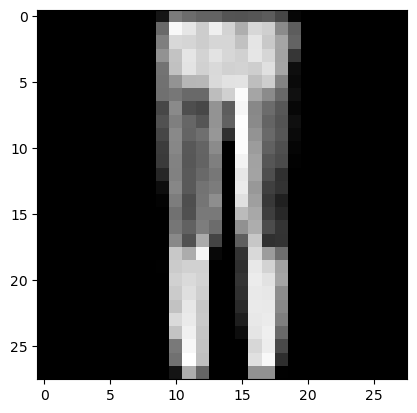

WRONG
Predicted: Coat, Number: 0.17772269248962402
Target: Shirt, Number: 6


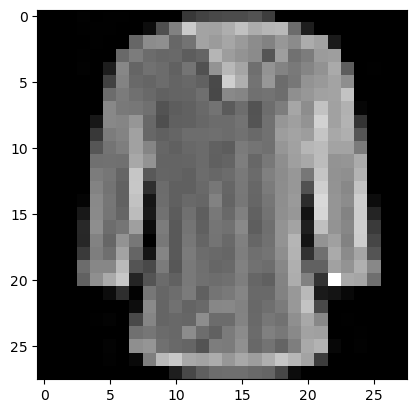

RIGHT
Predicted: Trouser, Number: 0.22963975369930267
Target: Trouser, Number: 1


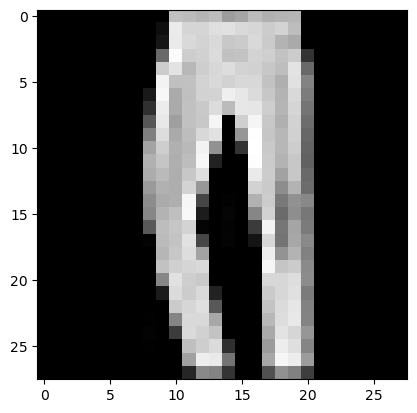

RIGHT
Predicted: Coat, Number: 0.1777564138174057
Target: Coat, Number: 4


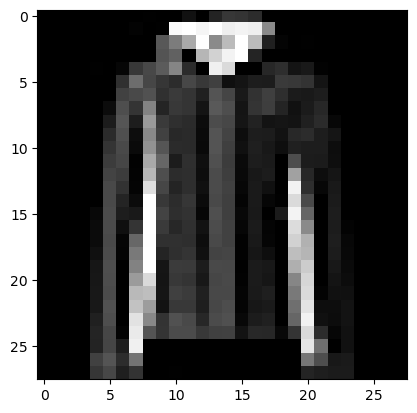

WRONG
Predicted: Coat, Number: 0.17872203886508942
Target: Shirt, Number: 6


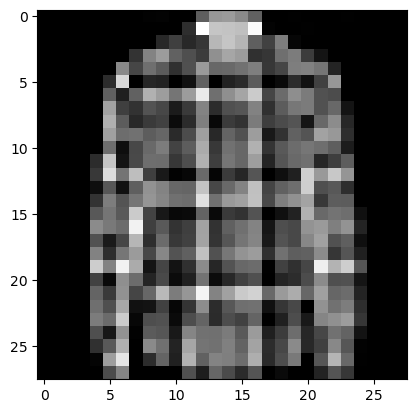

WRONG
Predicted: Sneaker, Number: 0.20210112631320953
Target: Sandal, Number: 5


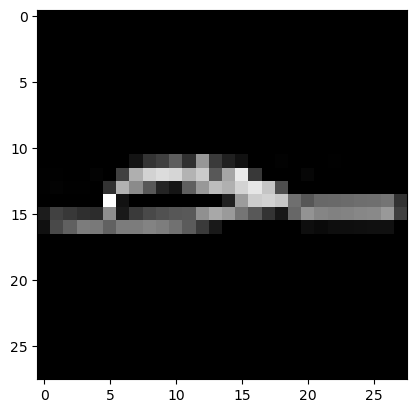

RIGHT
Predicted: Sneaker, Number: 0.20302867889404297
Target: Sneaker, Number: 7


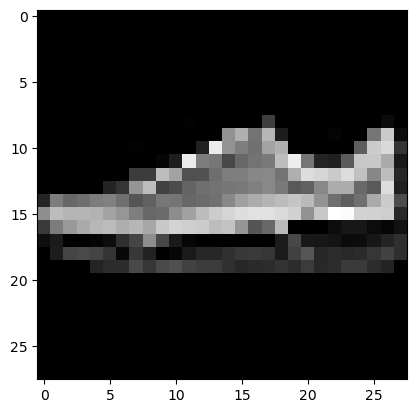

RIGHT
Predicted: Coat, Number: 0.17872373759746552
Target: Coat, Number: 4


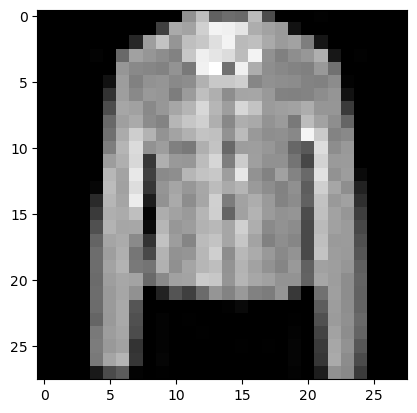

WRONG
Predicted: Sneaker, Number: 0.20156583189964294
Target: Sandal, Number: 5


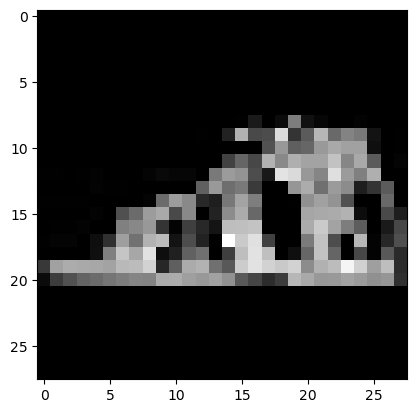

RIGHT
Predicted: Sneaker, Number: 0.18717224895954132
Target: Sneaker, Number: 7


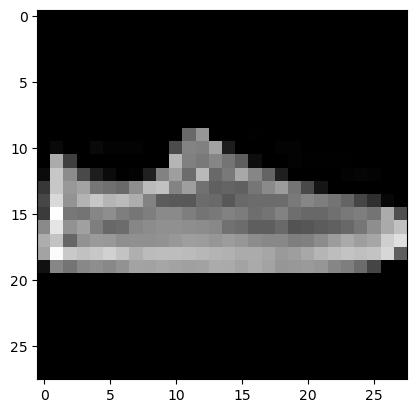

RIGHT
Predicted: Dress, Number: 0.228995680809021
Target: Dress, Number: 3


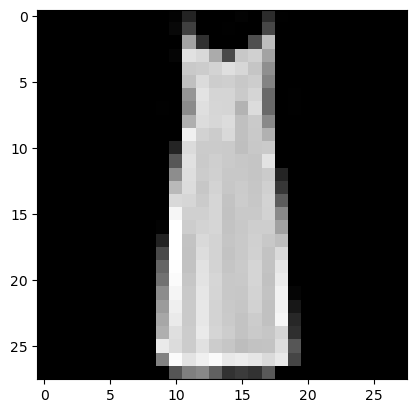

RIGHT
Predicted: Coat, Number: 0.178724005818367
Target: Coat, Number: 4


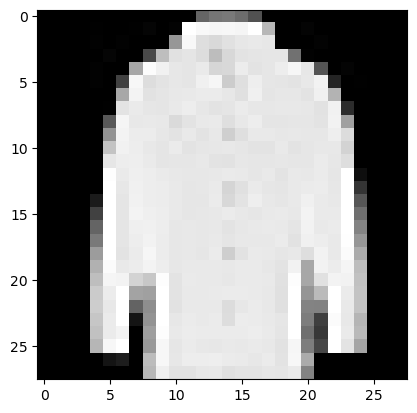

RIGHT
Predicted: Trouser, Number: 0.22958354651927948
Target: Trouser, Number: 1


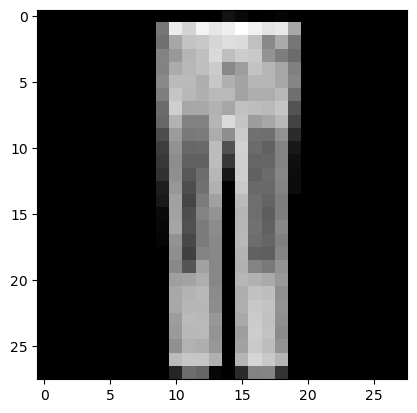

WRONG
Predicted: Coat, Number: 0.17865623533725739
Target: Pullover, Number: 2


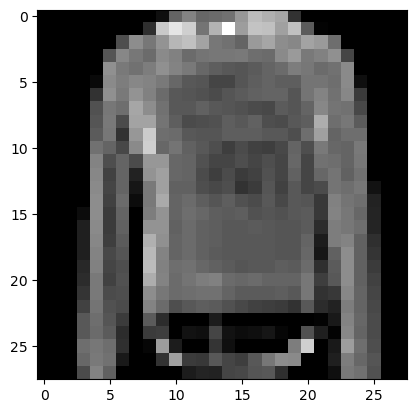

RIGHT
Predicted: Coat, Number: 0.17872337996959686
Target: Coat, Number: 4


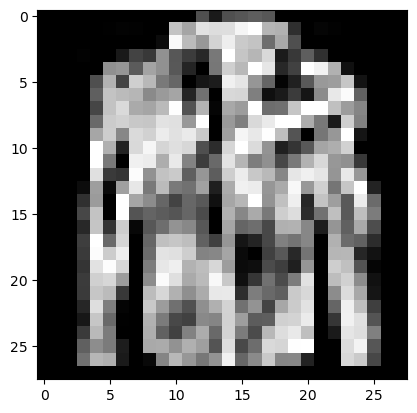

RIGHT
Predicted: Bag, Number: 0.22951310873031616
Target: Bag, Number: 8


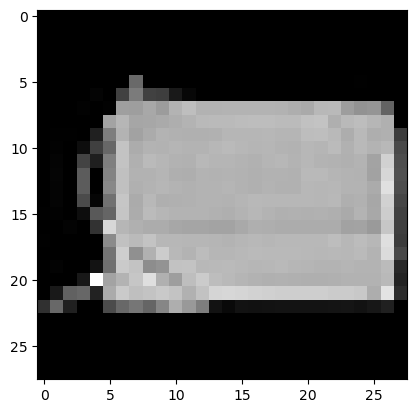

RIGHT
Predicted: T-Shirt, Number: 0.2199537456035614
Target: T-Shirt, Number: 0


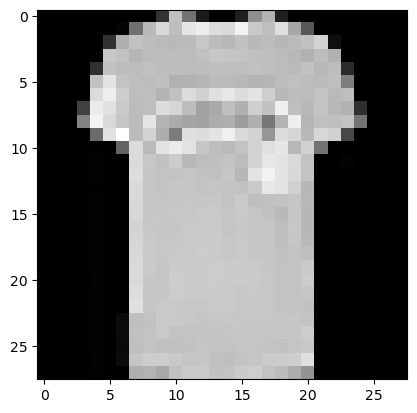

WRONG
Predicted: Shirt, Number: 0.15586324036121368
Target: Pullover, Number: 2


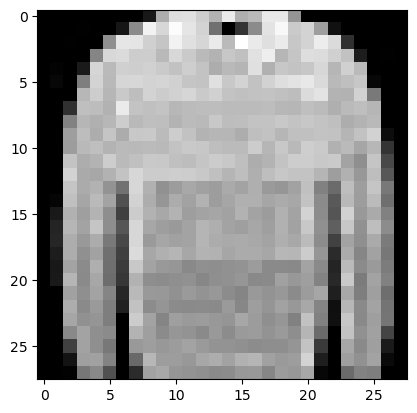

WRONG
Predicted: Sneaker, Number: 0.20401349663734436
Target: Sandal, Number: 5


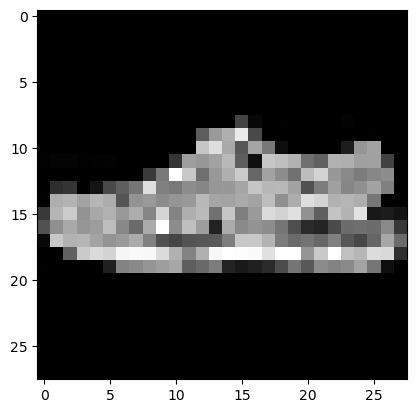

RIGHT
Predicted: Sneaker, Number: 0.20226316154003143
Target: Sneaker, Number: 7


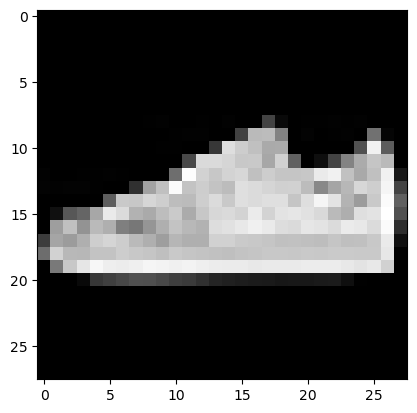

WRONG
Predicted: Sandal, Number: 0.20045261085033417
Target: Ankle Boot, Number: 9


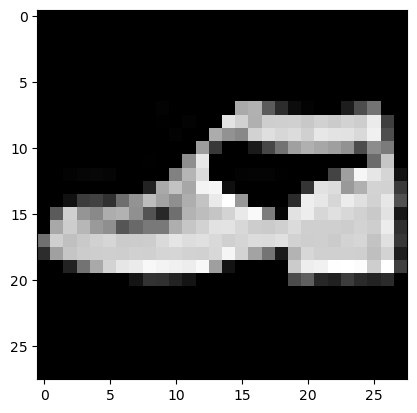

RIGHT
Predicted: Trouser, Number: 0.22963842749595642
Target: Trouser, Number: 1


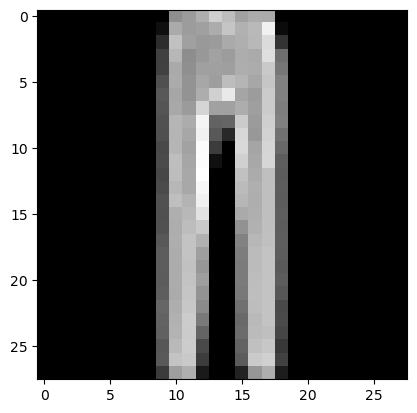

WRONG
Predicted: Pullover, Number: 0.17846384644508362
Target: Coat, Number: 4


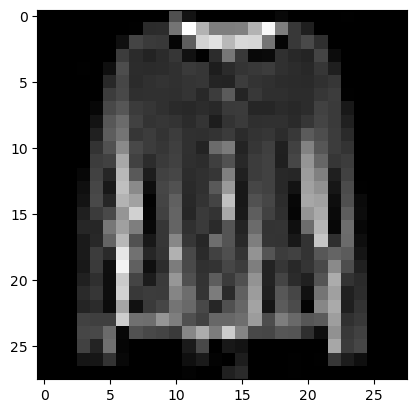

WRONG
Predicted: Coat, Number: 0.178724005818367
Target: Shirt, Number: 6


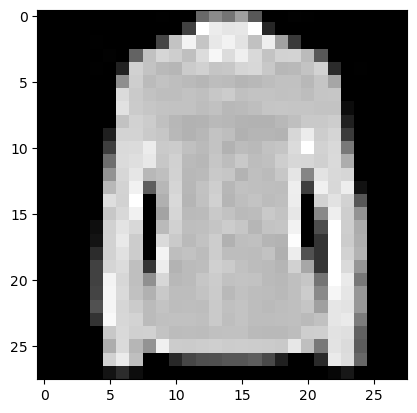

WRONG
Predicted: Dress, Number: 0.21149219572544098
Target: T-Shirt, Number: 0


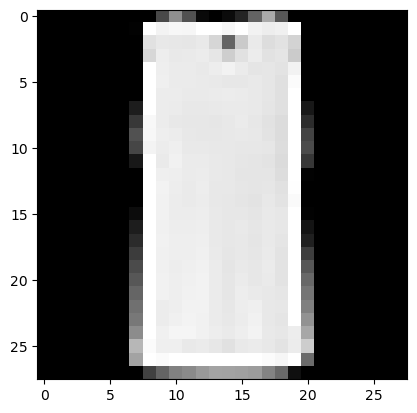

WRONG
Predicted: Sandal, Number: 0.20111824572086334
Target: Ankle Boot, Number: 9


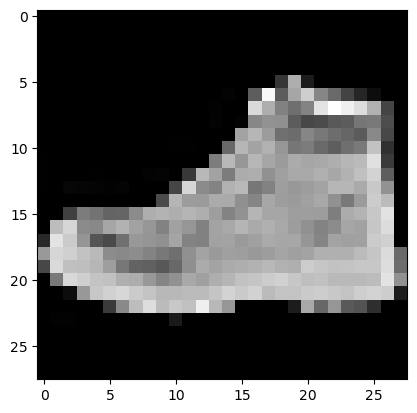

RIGHT
Predicted: Dress, Number: 0.21162985265254974
Target: Dress, Number: 3


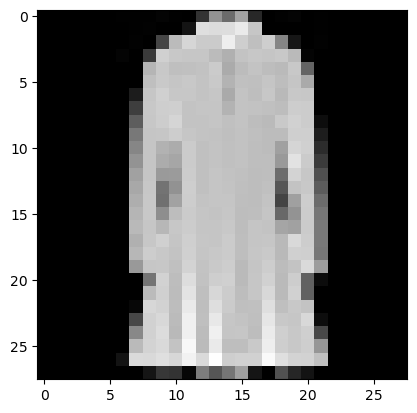

RIGHT
Predicted: Bag, Number: 0.2294732928276062
Target: Bag, Number: 8


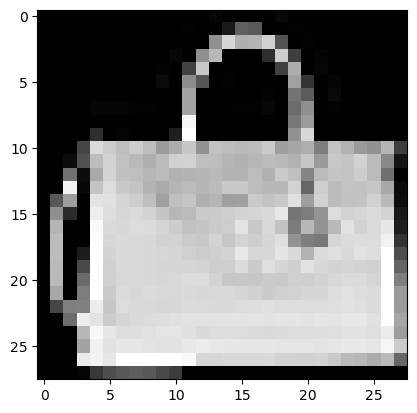

RIGHT
Predicted: Bag, Number: 0.2219490259885788
Target: Bag, Number: 8


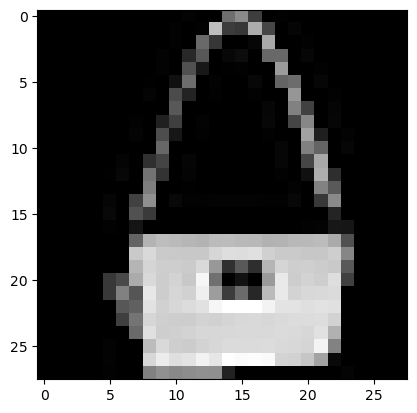

RIGHT
Predicted: Dress, Number: 0.22891618311405182
Target: Dress, Number: 3


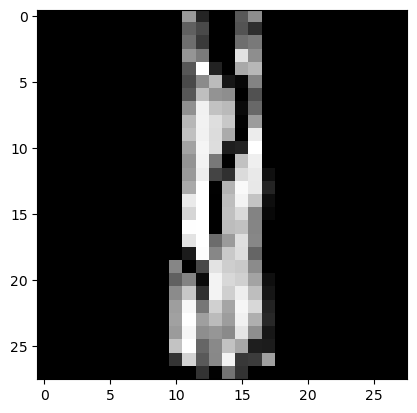

RIGHT
Predicted: Dress, Number: 0.22893279790878296
Target: Dress, Number: 3


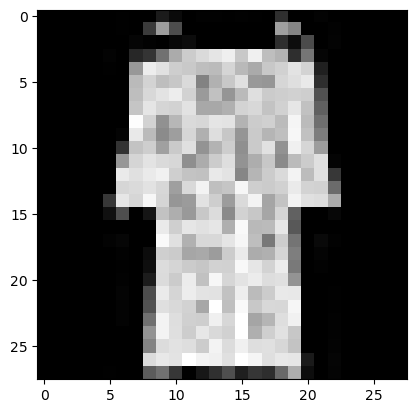

RIGHT
Predicted: Bag, Number: 0.22741638123989105
Target: Bag, Number: 8


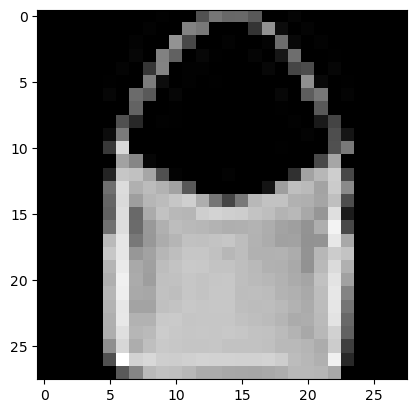

RIGHT
Predicted: T-Shirt, Number: 0.21762427687644958
Target: T-Shirt, Number: 0


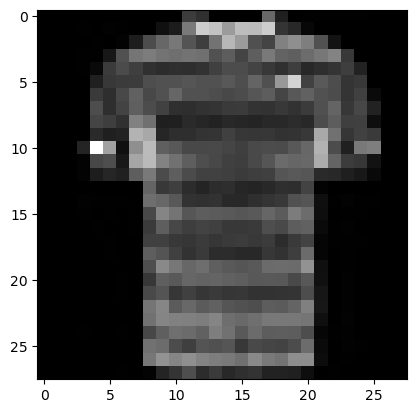

RIGHT
Predicted: Sneaker, Number: 0.2037244737148285
Target: Sneaker, Number: 7


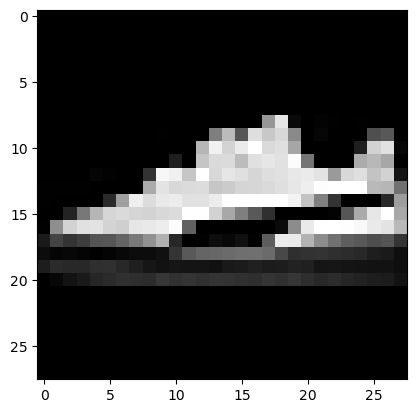

WRONG
Predicted: Sneaker, Number: 0.20196017622947693
Target: Sandal, Number: 5


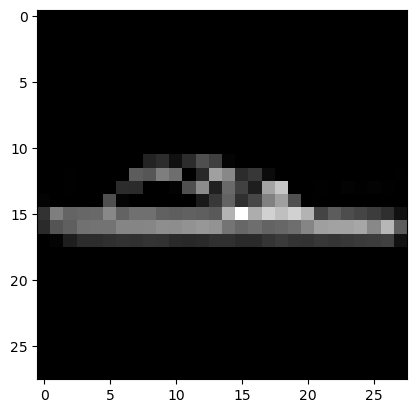

RIGHT
Predicted: Sneaker, Number: 0.20401422679424286
Target: Sneaker, Number: 7


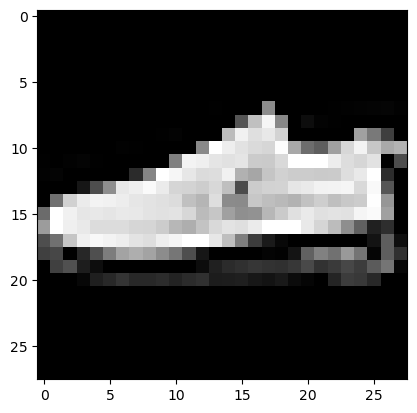

WRONG
Predicted: Sandal, Number: 0.20138733088970184
Target: Ankle Boot, Number: 9


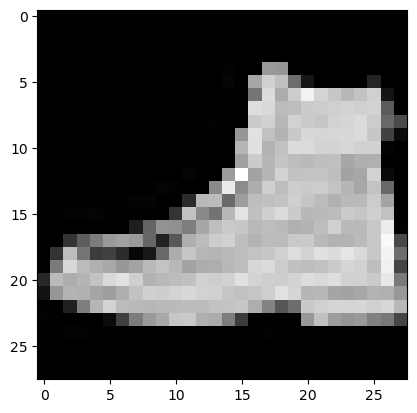

WRONG
Predicted: T-Shirt, Number: 0.2183394730091095
Target: Shirt, Number: 6


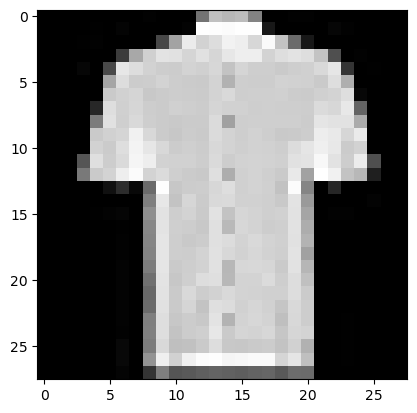

RIGHT
Predicted: Trouser, Number: 0.22964102029800415
Target: Trouser, Number: 1


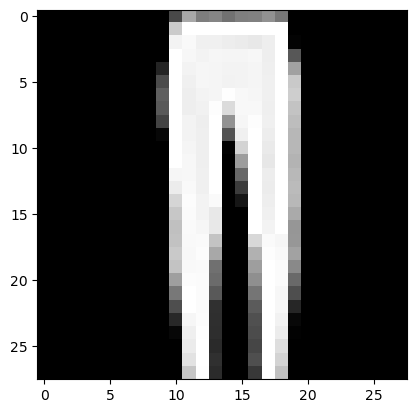

RIGHT
Predicted: Dress, Number: 0.18896032869815826
Target: Dress, Number: 3


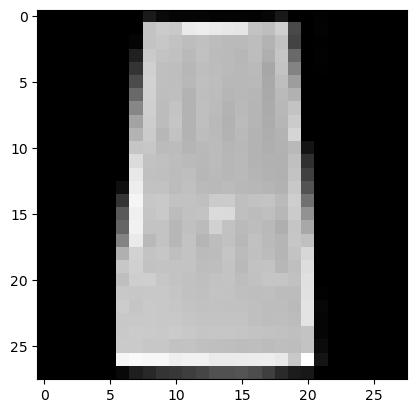

WRONG
Predicted: Sandal, Number: 0.1831752359867096
Target: Sneaker, Number: 7


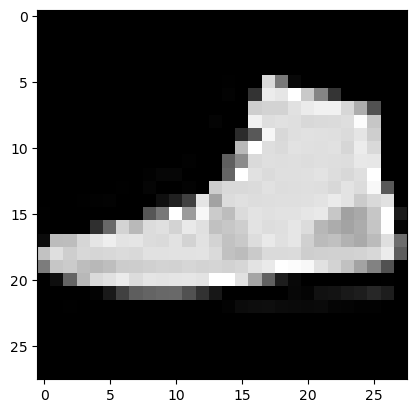

WRONG
Predicted: Coat, Number: 0.17872390151023865
Target: Shirt, Number: 6


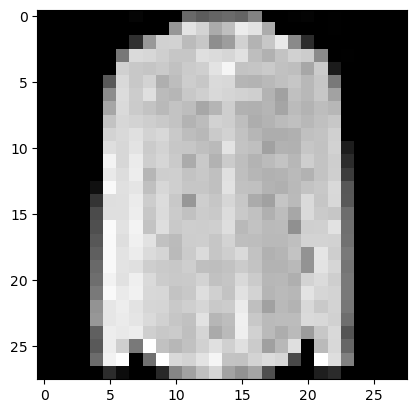

WRONG
Predicted: Sandal, Number: 0.2015303522348404
Target: Sneaker, Number: 7


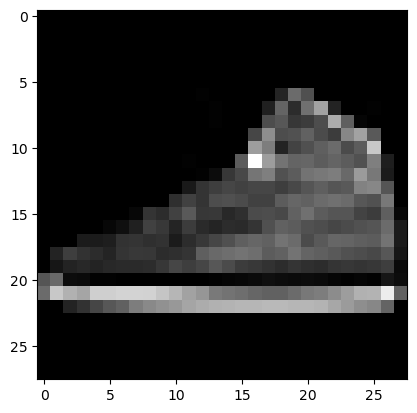

WRONG
Predicted: Coat, Number: 0.17872397601604462
Target: Pullover, Number: 2


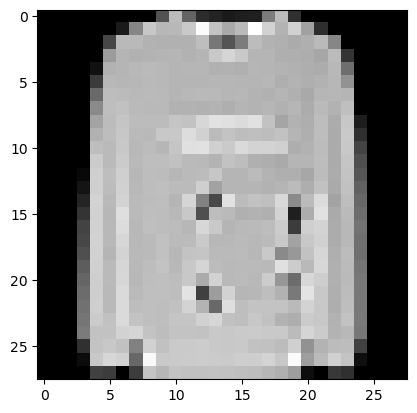

RIGHT
Predicted: Trouser, Number: 0.22958479821681976
Target: Trouser, Number: 1


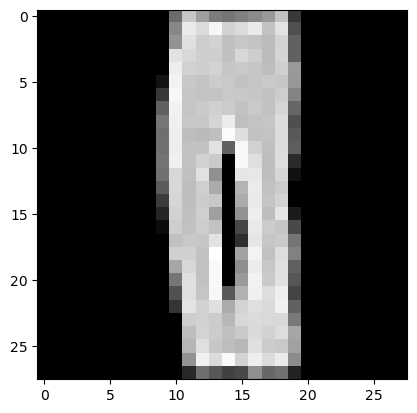

WRONG
Predicted: Coat, Number: 0.17871302366256714
Target: Pullover, Number: 2


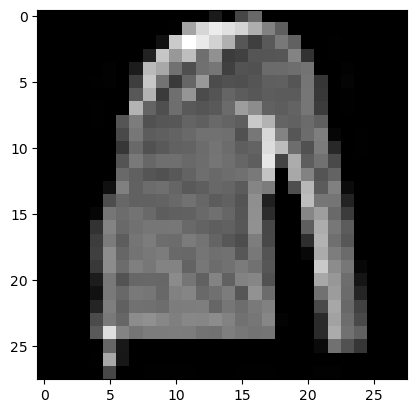

WRONG
Predicted: Coat, Number: 0.178724005818367
Target: Pullover, Number: 2


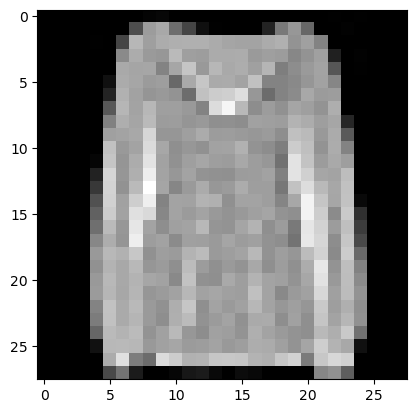

WRONG
Predicted: Pullover, Number: 0.17757484316825867
Target: Coat, Number: 4


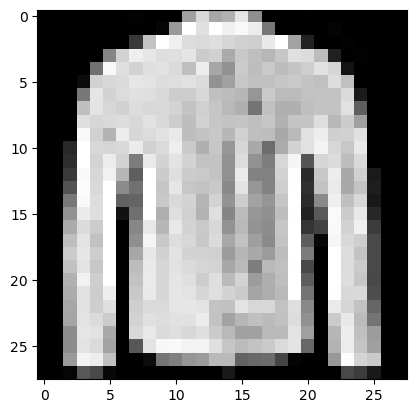

RIGHT
Predicted: Coat, Number: 0.17869161069393158
Target: Coat, Number: 4


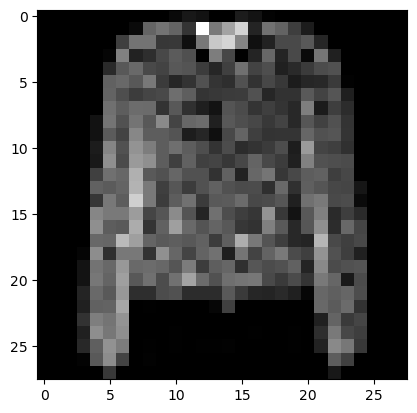

WRONG
Predicted: Sneaker, Number: 0.20050707459449768
Target: Sandal, Number: 5


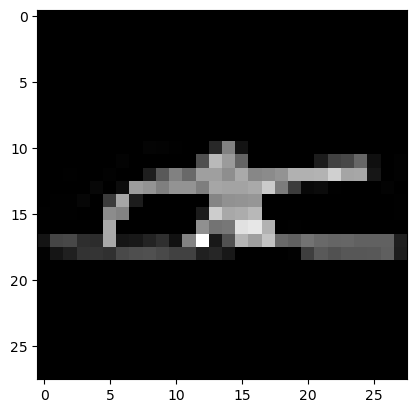

RIGHT
Predicted: Bag, Number: 0.22300675511360168
Target: Bag, Number: 8


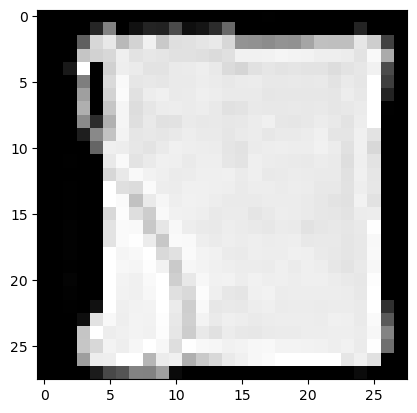

WRONG
Predicted: Coat, Number: 0.17963674664497375
Target: Pullover, Number: 2


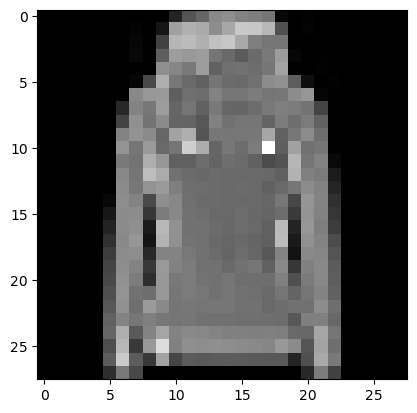

WRONG
Predicted: Shirt, Number: 0.17308378219604492
Target: Pullover, Number: 2


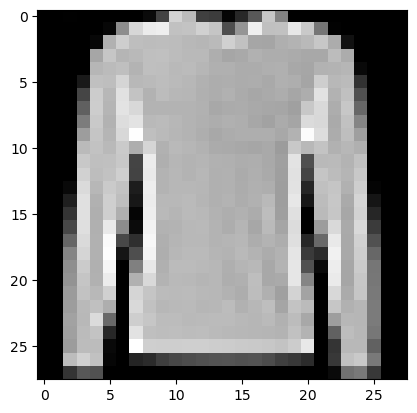

RIGHT
Predicted: Bag, Number: 0.22972507774829865
Target: Bag, Number: 8


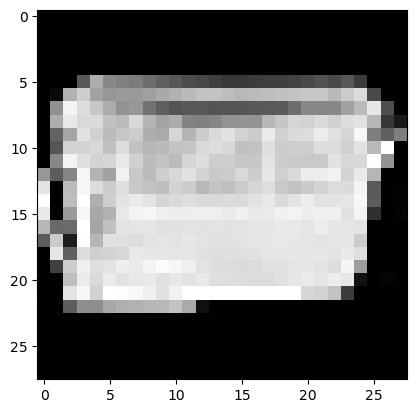

RIGHT
Predicted: Coat, Number: 0.17872382700443268
Target: Coat, Number: 4


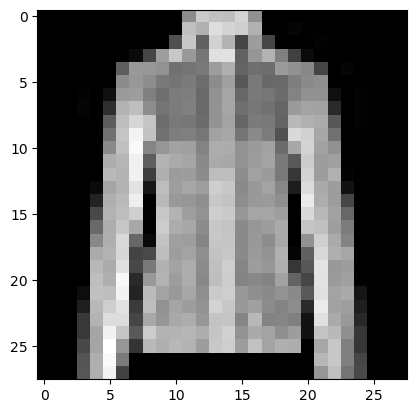

RIGHT
Predicted: Bag, Number: 0.22982102632522583
Target: Bag, Number: 8


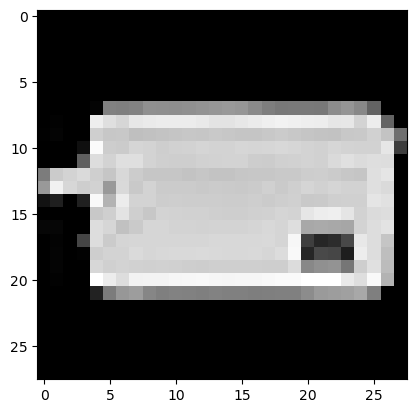

RIGHT
Predicted: T-Shirt, Number: 0.21807536482810974
Target: T-Shirt, Number: 0


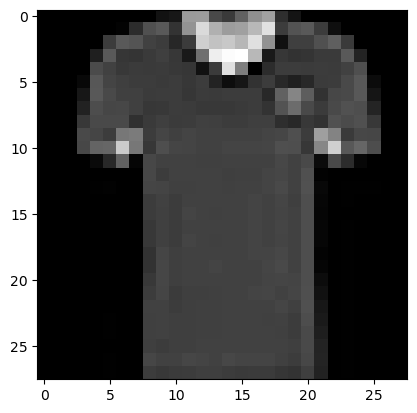

RIGHT
Predicted: Sneaker, Number: 0.20241302251815796
Target: Sneaker, Number: 7


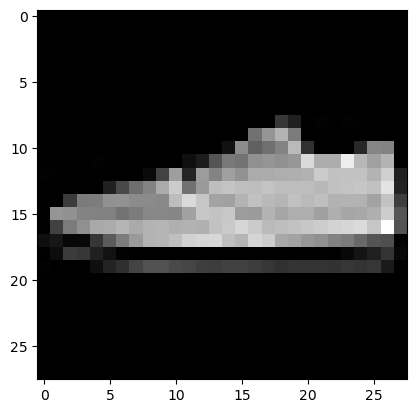

RIGHT
Predicted: Sneaker, Number: 0.20162566006183624
Target: Sneaker, Number: 7


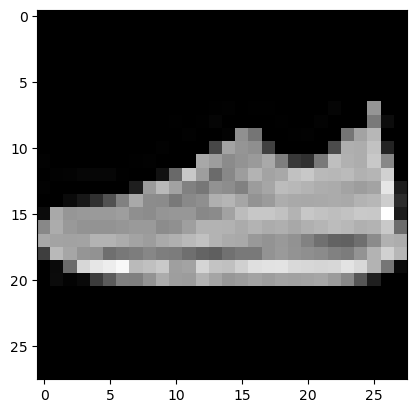

RIGHT
Predicted: Bag, Number: 0.2288263440132141
Target: Bag, Number: 8


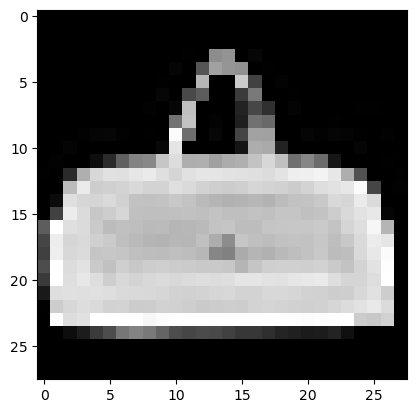

WRONG
Predicted: Sneaker, Number: 0.2014835625886917
Target: Sandal, Number: 5


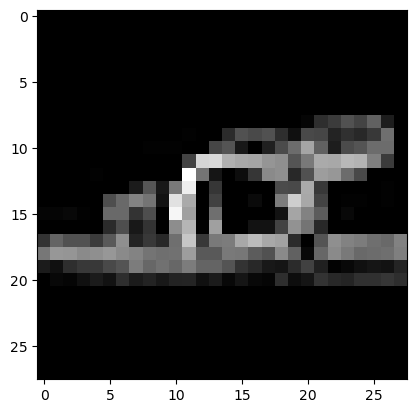

------------------------------------------------------
Total right: 56.25


In [ ]:
test_x, test_y = next(iter(test_dataloader))
test_x, test_y = test_x.to(device), test_y.to(device)

tot = 0
wrong = 0
right = 0

for xi, yi in zip(test_x, test_y):
    flattened = torch.flatten(xi)
    output = mlp(flattened)

    index = torch.argmax(output)

    if index.item() == yi.item():
        right += 1
        print("RIGHT")
    else: 
        print("WRONG")
        wrong += 1

    tot += 1

    
    print(f"Predicted: {labels_map[index.item()]}, Number: {torch.max(output).item()}")
    print(f"Target: {labels_map[yi.item()]}, Number: {yi.item()}")
    img = xi.cpu()
    plt.imshow(img[0], cmap="grey")
    plt.show()

right_ratio = right / tot * 100
print("------------------------------------------------------")
print(f"Total right: {right_ratio}")